In [64]:
#import libraries
import sys
import os
import gc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

%matplotlib inline

In [65]:
#checking folders
!ls /kaggle/input/

planets-dataset


In [66]:
#import and reading in datasets
sample_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
print(sample_df.shape)
sample_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [67]:
# combine adiditional test images to sample  submission
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_df.shape[0] == float(test1[0])+float(test2[0])

In [68]:
sample_df.shape

(61191, 2)

In [69]:
train_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [70]:
#print shape of train df
train_df.shape

(40479, 2)

In [71]:
#print shape of image
img_number = 15
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(img_number))

img.shape

(256, 256, 3)

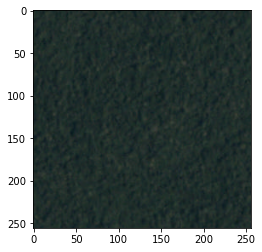

In [72]:
plt.imshow(img)

In [73]:
all_tags = [item for sublist in list(train_df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('there are {} non-unique total tags in all training images'.format(len(all_tags)))

there are 116278 non-unique total tags in all training images


In [74]:
#checking for unique tags
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train = train_df.copy()
train['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

#tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
print('There are {} unique tags'.format(len(unique_labels)))
#tags_counted_and_sorted.head()

['habitation', 'cultivation', 'clear', 'primary', 'agriculture', 'haze', 'road', 'cloudy', 'conventional_mine', 'bare_ground', 'slash_burn', 'blooming', 'blow_down', 'partly_cloudy', 'selective_logging', 'artisinal_mine', 'water']
There are 17 unique tags


In [75]:
assert len(train['image_name'].unique()) == train.shape[0]

In [76]:
#one hot encoding labels in the 'train_df'
for tag in unique_labels:
    train[tag] = train['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
#print head
train['image_name'] = train['image_name'].apply(lambda x: '{}.jpg'.format(x))
train.head()

,image_name,tags,habitation,cultivation,clear,primary,agriculture,haze,road,cloudy,conventional_mine,bare_ground,slash_burn,blooming,blow_down,partly_cloudy,selective_logging,artisinal_mine,water
0,train_0.jpg,haze primary,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,train_2.jpg,clear primary,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0


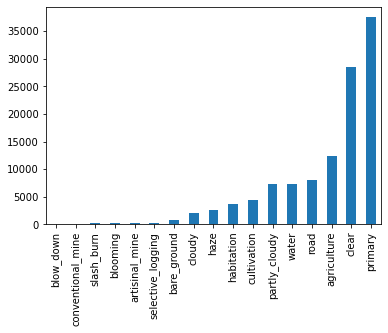

In [77]:
# Histogram of labels
train[unique_labels].sum().sort_values().plot.bar()

In [78]:
y_col = list(train.columns[2:])

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train, \
        directory='../input/planets-dataset/planet/planet/train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [79]:
from glob import glob
image_paths = sorted(glob('../input/planets-dataset/planet/planet/train-jpg/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

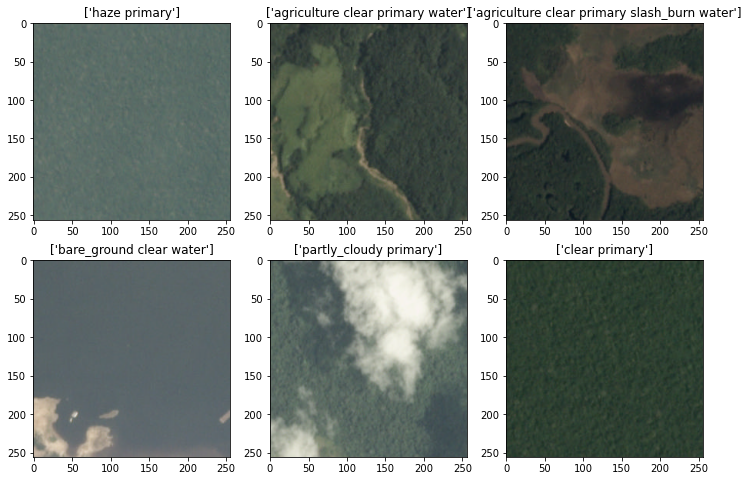

In [80]:
#Let's visualize some images to know what we are dealing with

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(train_df[train_df.image_name == image_names[i]].tags.values))

In [81]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

n_samples = 5000
rescaled_dim = 20

In [82]:
train_df['split_tags'] = train_df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(train_df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(name)),
                                    (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) 
                         for name in train_df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

(5000, 1600) (5000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0)

clf = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clf.fit(X_train, y_train)
    
score = fbeta_score(y_test, clf.predict(X_test), beta=2, average=None)
avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [84]:
print('Mean F2 test score {}'.format(avg_sample_score))
print('F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Mean F2 test score 0.6983348971667915
F2 test scores per tag:


[('primary', 0.9667024704618691),
 ('clear', 0.8839086859688198),
 ('cloudy', 0.4850746268656716),
 ('agriculture', 0.3925304878048781),
 ('road', 0.28488372093023256),
 ('water', 0.1857142857142857),
 ('artisinal_mine', 0.17857142857142855),
 ('partly_cloudy', 0.1706036745406824),
 ('habitation', 0.1485148514851485),
 ('cultivation', 0.08684863523573201),
 ('bare_ground', 0.05555555555555556),
 ('haze', 0.0),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('selective_logging', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0)]

In [86]:
samples= 40669
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample_df.head(samples)['image_name'].values]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

(40669, 1600)

In [87]:
y_sub = clf.predict(X_sub)
all_test_tags = []
for index in range(y_sub.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))
all_test_tags[0:20]

['clear primary',
 'clear primary',
 'clear habitation primary road water',
 'clear primary',
 'partly_cloudy primary',
 'clear primary',
 'primary',
 'clear road',
 'clear primary',
 'primary',
 'partly_cloudy primary',
 'agriculture clear primary water',
 'cloudy',
 'clear primary',
 'clear primary',
 'clear primary',
 'clear primary water',
 'agriculture clear primary',
 'clear primary',
 'clear primary']

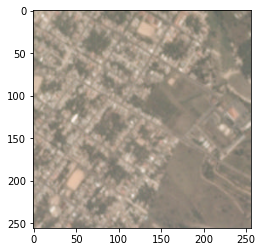

In [88]:
test_images = [plt.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(name)) 
               for name in sample_df.head(20)['image_name'].values]
plt.imshow(test_images[7])

In [96]:
sample_df.head(samples)['tags'] = all_test_tags
sample_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear habitation primary road water
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [97]:
#submit.to_csv('submit3.csv', index=False)
sample_df.to_csv('submit4.csv'.format(avg_sample_score), index=False)

In [98]:
sample_df.to_csv('submit5.csv', index=False)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [32]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [33]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=3, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [34]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [35]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generate  80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generate 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [36]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [37]:
step_train_size+step_val_size

317

In [39]:
model_1 = build_model() # building a sequential model for training

# fitting the model
model_1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=2, callbacks=[save_best_check_point])

Epoch 1/2
253/253 [==============================] - 120s 475ms/step - loss: 46.6234 - multi_label_acc: 0.8566 - fbeta: 0.6099 - val_loss: 52.4265 - val_multi_label_acc: 0.8677 - val_fbeta: 0.6591
Epoch 2/2
253/253 [==============================] - 97s 384ms/step - loss: 9.2751 - multi_label_acc: 0.8612 - fbeta: 0.6133 - val_loss: 9.3602 - val_multi_label_acc: 0.8592 - val_fbeta: 0.6340


In [40]:
model_2 = build_model() # building a sequential model for testing

#loading in the weights of the trained model
model_2.load_weights('best_model.hdf5')

In [99]:
submission = sample_df.copy()
submission['image_name'] = submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
submission.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,clear habitation primary road water
3,test_3.jpg,clear primary
4,test_4.jpg,partly_cloudy primary


In [100]:
# removing the .jpg from 'iamge_name' 
submission['image_name'] = submission['image_name'].apply(lambda x: x[:-4])
submission.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,clear habitation primary road water
3,test_3,clear primary
4,test_4,partly_cloudy primary


In [101]:
submission.to_csv('submit2.csv', index=False) # saving the predictions